In [ ]:
#networkx para teoría de grafos, matplot para gráficar, random para generar números aleatorios, stats para la entropia y solve para optimizar.
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp 
from scipy import stats as st
import math 
from scipy.optimize import fsolve

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
cd "/gdrive/MyDrive/Apuntes papers "

/gdrive/MyDrive/Apuntes papers 


In [ ]:
def Degree_Sec_Generator(Probabilidad_Acumulada,longitud_Secuencia):
  """
  (Vector Probabilidada Acumulada, Longitud Secuencia) -------> Secuencia de enteros con la distribución del vector
  """
  Degree_Sequence = []
  sum = 0
  for i in range(longitud_Secuencia):
    k = st.uniform.rvs(scale = Probabilidad_Acumulada[len(Probabilidad_Acumulada)-1]) #Se generan números aleatoriamente entre 0 y 0.9999
    for j in range(len(Probabilidad_Acumulada)-2):
      if k <= Probabilidad_Acumulada[j+2]: # Asocia un entero positivo a cada número entre 0-0.9999
        Degree_Sequence.append(j+2) #construye el vector con los enteros positivos asociados a los números entre 0-1
        break
  return Degree_Sequence

In [ ]:
def maxent_generator(cum_probability,number_nodes):
  """
  (cum_probability,number_nodes) -----> G
  esta función recibe vector de probabilidades acumulada y un entero, te entrega un grafo generado con el algoritmo expuesto
  en el proyecto que sustenta este respositorio
  """
  for k in range(10000):
          Degree_Sequence = Degree_Sec_Generator(cum_probability,number_nodes)
          if nx.is_valid_degree_sequence_havel_hakimi(Degree_Sequence) == True:
            if nx.is_connected(nx.havel_hakimi_graph(Degree_Sequence)) == True:
              Degree_Sequence.sort()
              G = nx.havel_hakimi_graph(Degree_Sequence)
              break
  nx.double_edge_swap(G,nswap=300,max_tries=150000)
  return G

In [ ]:
#este algoritmo es para muestrear secuencias de grado acorde a una distribución de probabilidad y calcular la secuencia de grado promedio
def Deg_Sec_Prom(Muestreo_seq,Number_nodes,Probability_distribution):
  """
  (num_muestras,number_nodes,cum_prob_distribution) ----------------> (degree_sequence_prom)
  esta función hace uso de Degree_Sec_Generator y networkx
  """
  degree_sequences = [] #matriz donde se guardaran las distintas secuencias a muestrear
  for i in range(Muestreo_seq): #por cada i generamos una secuencia
    degree_sequences.append([]) 
    for k in range(10000):
      Degree_Sequence = Degree_Sec_Generator(Probability_distribution,Number_nodes) #generamos la secuencia de números
      if nx.is_valid_degree_sequence_havel_hakimi(Degree_Sequence) == True:
        if nx.is_connected(nx.havel_hakimi_graph(Degree_Sequence)) == True: #validamos que sea apta para generar un grafo simple
          Degree_Sequence.sort() #la ordenamos, esto con el fin de darle una identidad a los nodos acorde a su puesto en el ranking de medida
          for l in range(len(Degree_Sequence)): #este for es para agregar la secuencia de grado a la matriz creada inicialmente
            degree_sequences[i].append(Degree_Sequence[l])
          break

  Degree_sequence_prom = []
  for i in range(Number_nodes):
    sum = 0
    for j in range(Muestreo_seq):
      sum = sum + degree_sequences[j][i]
    Degree_sequence_prom.append(sum/Muestreo_seq)
  return Degree_sequence_prom

In [ ]:
# este programa te calcula los multiplicadores de lagrange dada una secuencia de grado, para el ensamble canonico.
def multp_lagrange_canonico(degree_sequence):
  """
  (degree_sequence) ----> (lagrange_multiplicators_canonicalensemble)
  esta función te recibe una secuencia de grado, te la impone como ligadura en un ensamble canonico de grafos simples y 
  te entrega un vector con los multiplicadores de lagrange ordenados de menor a mayor acorde al grado de la restricción asociada 
  (para más información ver soft configuration model y Newm)
  """
  def lagrange_eq(lagrange_multiplicators, degree_sequence):
    n = len(degree_sequence)
    matrix = np.zeros((n,n))
    for i in range(n):
      for j in range(n):
        matrix[i][j] = 1/(math.exp(lagrange_multiplicators[i] + lagrange_multiplicators[j]) + 1)
      matrix[i][i] = 0
    sums = []
    for i in range(n):
      sum = 0
      for j in range(n):
        sum = sum + matrix[i][j]
      sums.append(sum)
    resultado = np.zeros(n)
    for i in range(n):
      resultado[i] = sums[i] - degree_sequence[i] 
    return resultado

  x0 = np.zeros(len(degree_sequence))
  def lagrange(lagrange_multiplicators):
    k = lagrange_eq(lagrange_multiplicators,degree_sequence)
    return k
  #hasta acá lo que se ha hecho es definir las funciones a resolver acorde a los resultados del ensamble canonico 
  #(para más información buscar soft configuration model)
  multiplicators = fsolve(lagrange,x0) #se resuelve el conjunto de ecuaciones hallando los multiplicadores
  return multiplicators

In [ ]:
def canonical_matrix(Multiplicadores_Lagrange):
  Adyacencia_promedio = []
  for i in range(len(Multiplicadores_Lagrange)):
    Adyacencia_promedio.append([])
    for j in range(len(Multiplicadores_Lagrange)):
      Adyacencia_promedio[i].append(1/(1 + math.exp((Multiplicadores_Lagrange[i] + Multiplicadores_Lagrange[j]))))
  for i in range(len(Multiplicadores_Lagrange)):
    Adyacencia_promedio[i][i] = 0
  return Adyacencia_promedio

In [ ]:
#este algoritmo muestrea el ensamble de redes por medio del algoritmo de máxima entropía y te entrega su matriz de adyacencia promedio

def muestra_ensamble_maxent(muestra,number_of_nodes,P):
  """
  (num_muestra, num_nodes,cum_probab_distribut) -------> (Degree_sequence_prom,adjacencia_insilico)
  """
  connectivity_matrix = np.zeros((muestra, number_of_nodes, number_of_nodes))

  for l in range(muestra):
      G = maxent_generator(P,number_of_nodes) #generamos un grafo usando el algoritmo de maxima entropia
      adjacency = nx.adjacency_matrix(G)
      for i in range(number_of_nodes):
        for j in range(number_of_nodes):
          connectivity_matrix[l][i][j] = adjacency[(i,j)] #guardamos las matrices de adyacencias de los grafos muestreados
  adjacencia_insilico = np.zeros((number_of_nodes,number_of_nodes)) 

  for i in range(number_of_nodes):
    for j in range(number_of_nodes):
      adjprom = 0
      for l in range(muestra):
        adjprom = adjprom + connectivity_matrix[l][i][j]
      adjprom = adjprom/muestra #promediamos matrices de adyacencia
      adjacencia_insilico[i][j] = adjprom 
  return adjacencia_insilico

In [ ]:
def pareto_cumm_probabilities(particiones,xfin, distribution = st.pareto.cdf):
  """
  (particiones,xfin) -----> (probability_cum_vector)
  Esta función recibe un xfinal hasta donde sumar y un número de particiones
  juntos definen la longitud y el valor máximo del vector resultante
  """
  dx = xfin/particiones
  x = []
  probability_cum_vector = []
  for i in range(particiones):
    equis = 1 + dx*i
    x.append(equis)
    pes = st.pareto.cdf(x[i],2.4) #se eligió un coeficiente de 2.4 para la distribución de pareto
    probability_cum_vector.append(pes)
  return probability_cum_vector, x # entrega como resultado el vector y los valores de x asociados


[0.0, 0.3556936358690983, 0.555576213215978, 0.6777820397832639, 0.7573274203432596, 0.8116730670084402, 0.8502618252988154, 0.8785375180530715, 0.8998050749942583, 0.9161584990681335, 0.9289730755441961, 0.939180152927707, 0.9474273431844457, 0.954175467134707, 0.9597591522638463, 0.9644258024026517, 0.9683612965837913, 0.9717073202849449, 0.9745732908045747, 0.9770447130400588, 0.9791891311818683, 0.9810604319800171, 0.9827019990690722, 0.984149054391717, 0.9854304164906333, 0.986569835136072, 0.9875870144999003, 0.9884984048490109, 0.9893178204353336, 0.9900569256423861, 0.9907256203781557, 0.9913323477695042, 0.9918843414666063, 0.9923878256629773, 0.9928481778343357, 0.9932700618897188, 0.9936575376943522, 0.9940141516120607, 0.9943430117154026, 0.9946468505446185, 0.9949280777039424, 0.9951888241232077, 0.995430979452487, 0.9956562237742197, 0.9958660545932665, 0.9960618098872679, 0.9962446878574354, 0.9964157639057252, 0.9965760052722796, 0.9967262836924576, 0.9968673863721358, 

In [ ]:

xfin = 30
Nnodes = 100
max_degree = Nnodes-1
P, x = pareto_cumm_probabilities(max_degree,xfin) #creamos el vector de probabilidades acumulada


Sec_prom = Deg_Sec_Prom(150,Nnodes,P)

[0.0, 0.47020340554389395, 0.6792465261044549, 0.7881560151645541, 0.8512494461551469, 0.8906934885200644, 0.9168093765187219, 0.9348935348885984, 0.9478751052156081, 0.9574733484956953, 0.9647475327833914, 0.9703771413828335, 0.9748131403726383, 0.9783636895091364, 0.9812447521290343, 0.9836110609407347, 0.9855756612162311, 0.9872225860543697, 0.9886152785957001, 0.9898023105002605, 0.9908213407942743, 0.9917019050655764, 0.992467412158988, 0.993136594485273, 0.9937245755883224, 0.9942436656637781, 0.9947039610942441, 0.9951138010358613, 0.9954801185338132, 0.9958087129828465, 0.9961044633441081, 0.9963714963222688, 0.9966133200021017, 0.9968329307790444, 0.9970328994821294, 0.9972154411672914, 0.9973824720076433, 0.9975356559223402, 0.9976764429948949, 0.9978061012838091, 0.9979257432861948, 0.9980363480518987, 0.99813877974193, 0.9982338032663328, 0.9983220975123309, 0.998404266575637, 0.9984808493302311, 0.9985523276101489, 0.9986191332273923, 0.9986816540103497, 0.9987402390150265

In [ ]:
multipliers = multp_lagrange_canonico(Sec_prom)

In [ ]:
adj = canonical_matrix(multipliers)

In [ ]:
adj_insilico = muestra_ensamble_maxent(150,Nnodes,P)
multipliers2 = multp_lagrange_canonico(Sec_prom2)
adj2 = canonical_matrix(multipliers2)

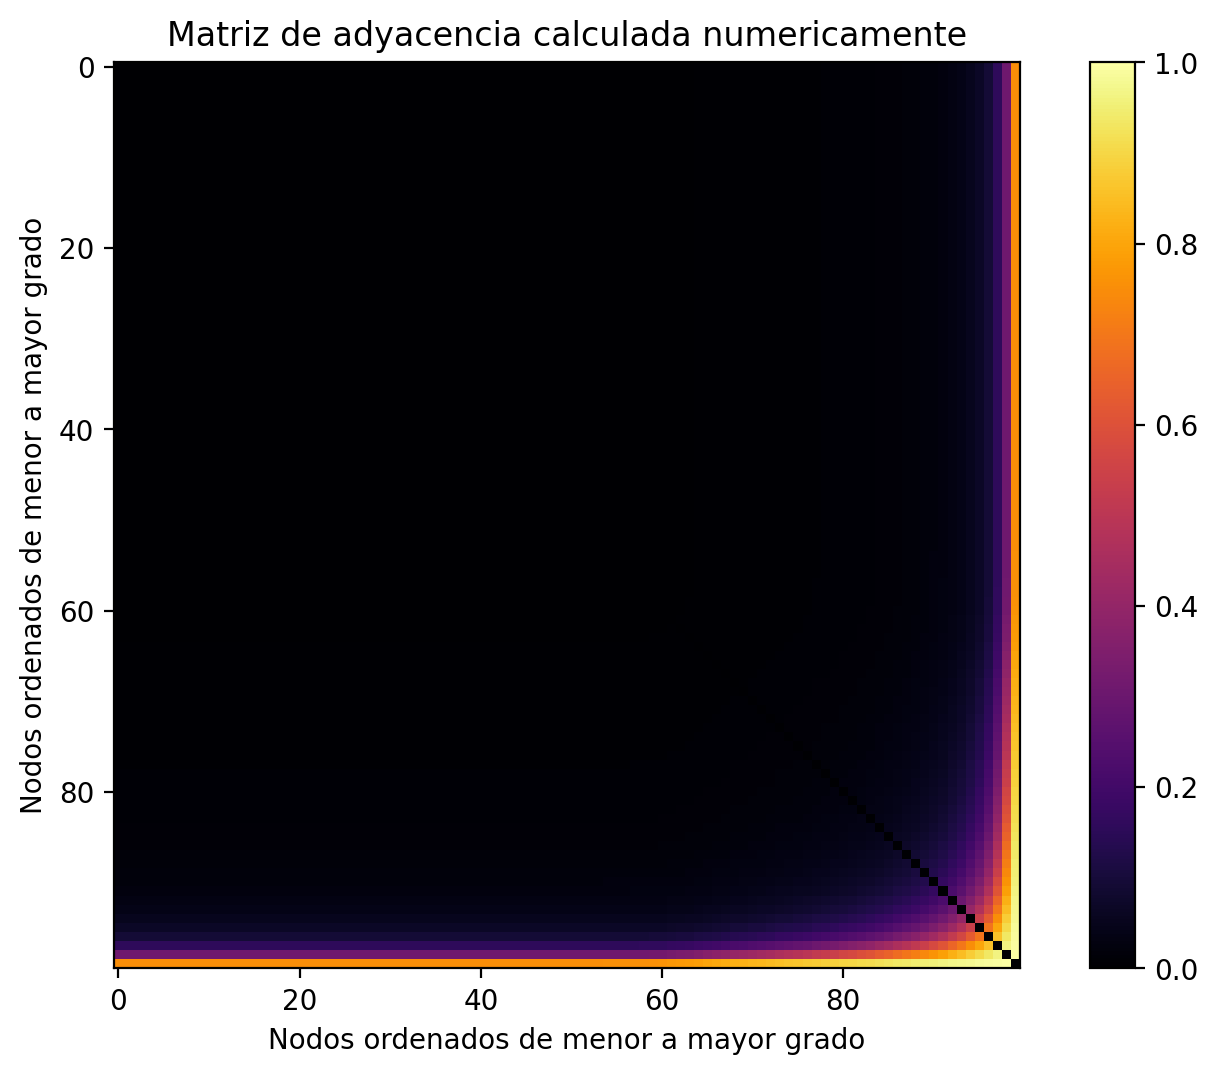

In [ ]:
fig = plt.figure(figsize=(9,6),dpi = 200)
plt.imshow(adj,cmap = "inferno",vmin=0,vmax= 1)
plt.title("Matriz de adyacencia calculada numericamente")
plt.xlabel("Nodos ordenados de menor a mayor grado")
plt.ylabel("Nodos ordenados de menor a mayor grado")
plt.colorbar()
plt.savefig("adj_numerica_canonico.jpg", bbox_inches='tight', dpi=300)
plt.show()


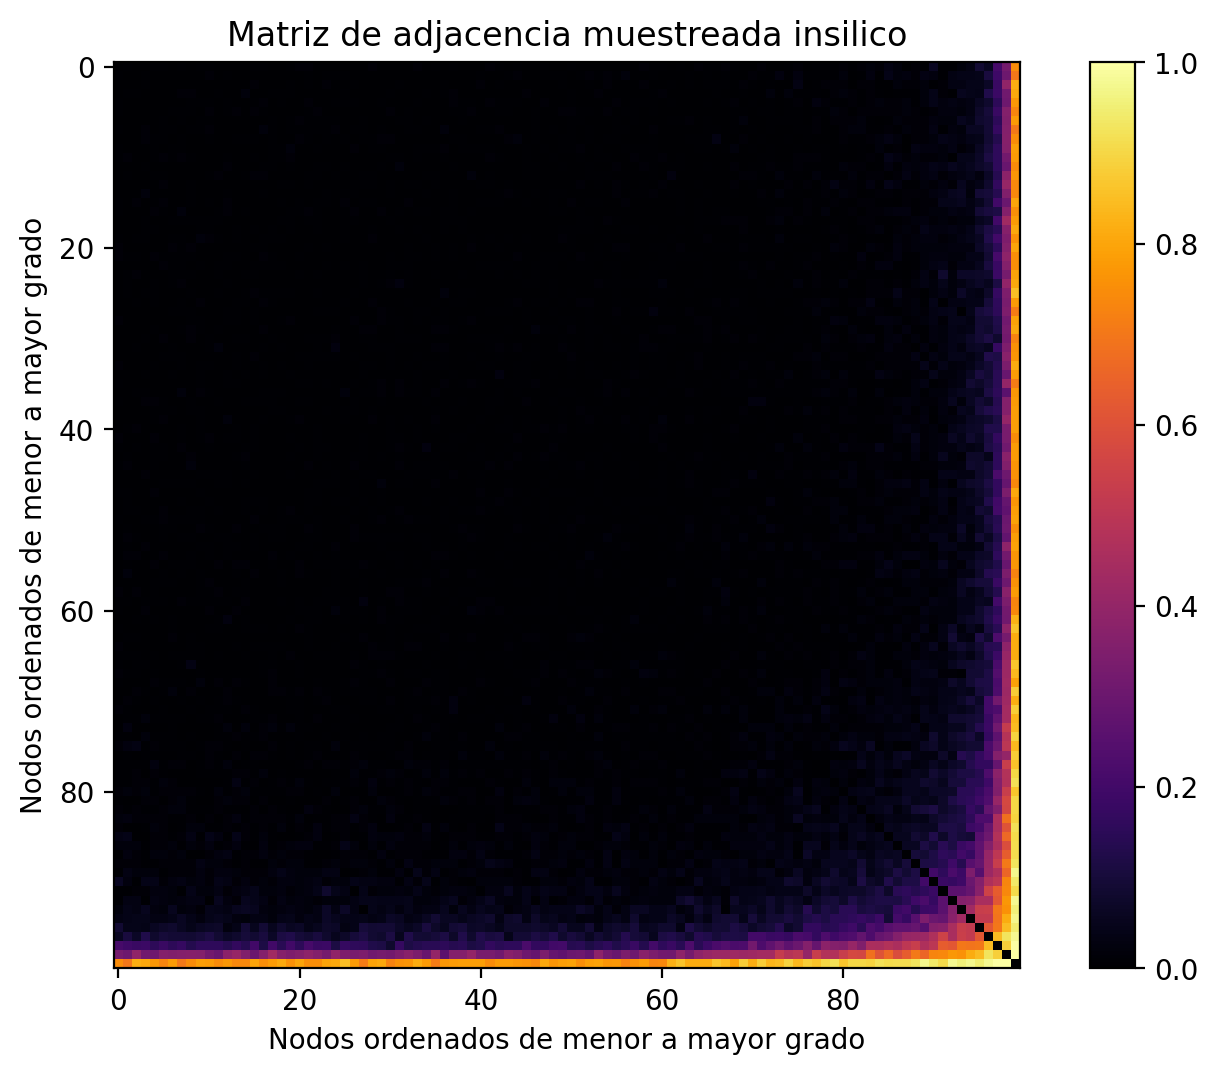

In [ ]:
fig = plt.figure(figsize=(9,6), dpi = 200)
plt.imshow(adj_insilico,cmap = "inferno")
plt.xlabel("Nodos")
plt.ylabel("Nodos")
plt.title("Matriz de adjacencia muestreada insilico")
plt.xlabel("Nodos ordenados de menor a mayor grado")
plt.ylabel("Nodos ordenados de menor a mayor grado")
plt.colorbar()
plt.savefig("adj_muestreada_insilico.jpg", bbox_inches='tight', dpi=300)
plt.show()


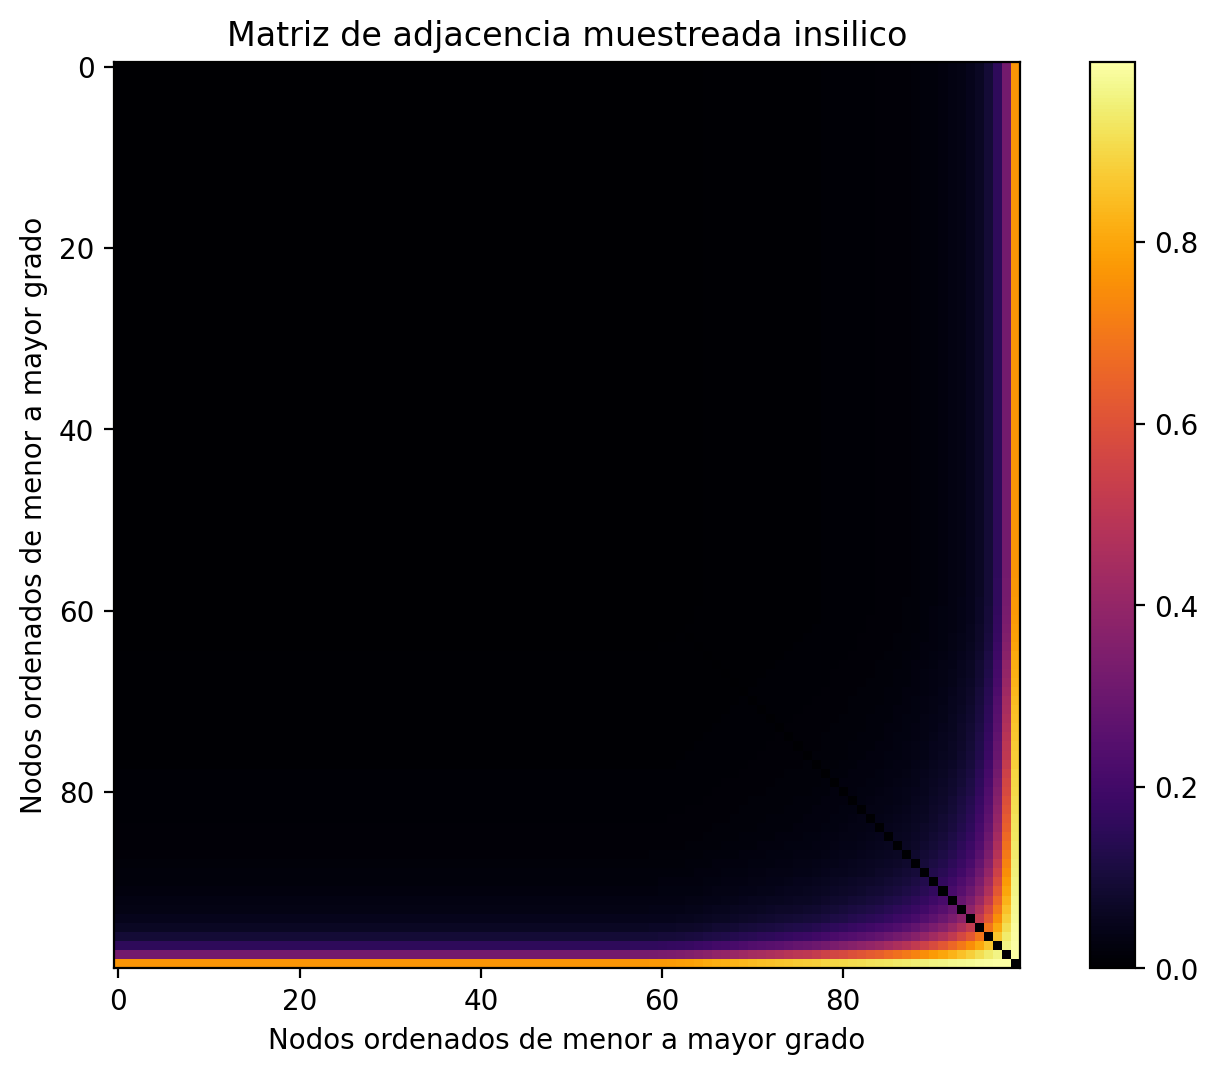

In [ ]:
fig = plt.figure(figsize=(9,6), dpi = 200)
plt.imshow(adj2,cmap = "inferno")
plt.xlabel("Nodos")
plt.ylabel("Nodos")
plt.title("Matriz de adjacencia muestreada insilico")
plt.xlabel("Nodos ordenados de menor a mayor grado")
plt.ylabel("Nodos ordenados de menor a mayor grado")
plt.colorbar()
plt.savefig("adj_numerica_insilico.jpg", bbox_inches='tight', dpi=300)
plt.show()


In [ ]:
DIFF = np.zeros((len(adj),len(adj)))
for i in range(len(adj)):
  for j in range(len(adj[i])):
    DIFF[i][j] = adj[i][j] - adj_insilico[i][j]


DIFF2 = np.zeros((len(adj2),len(adj2)))
for i in range(len(adj2)):
  for j in range(len(adj2[i])):
    DIFF2[i][j] = adj2[i][j] - adj_insilico[i][j]


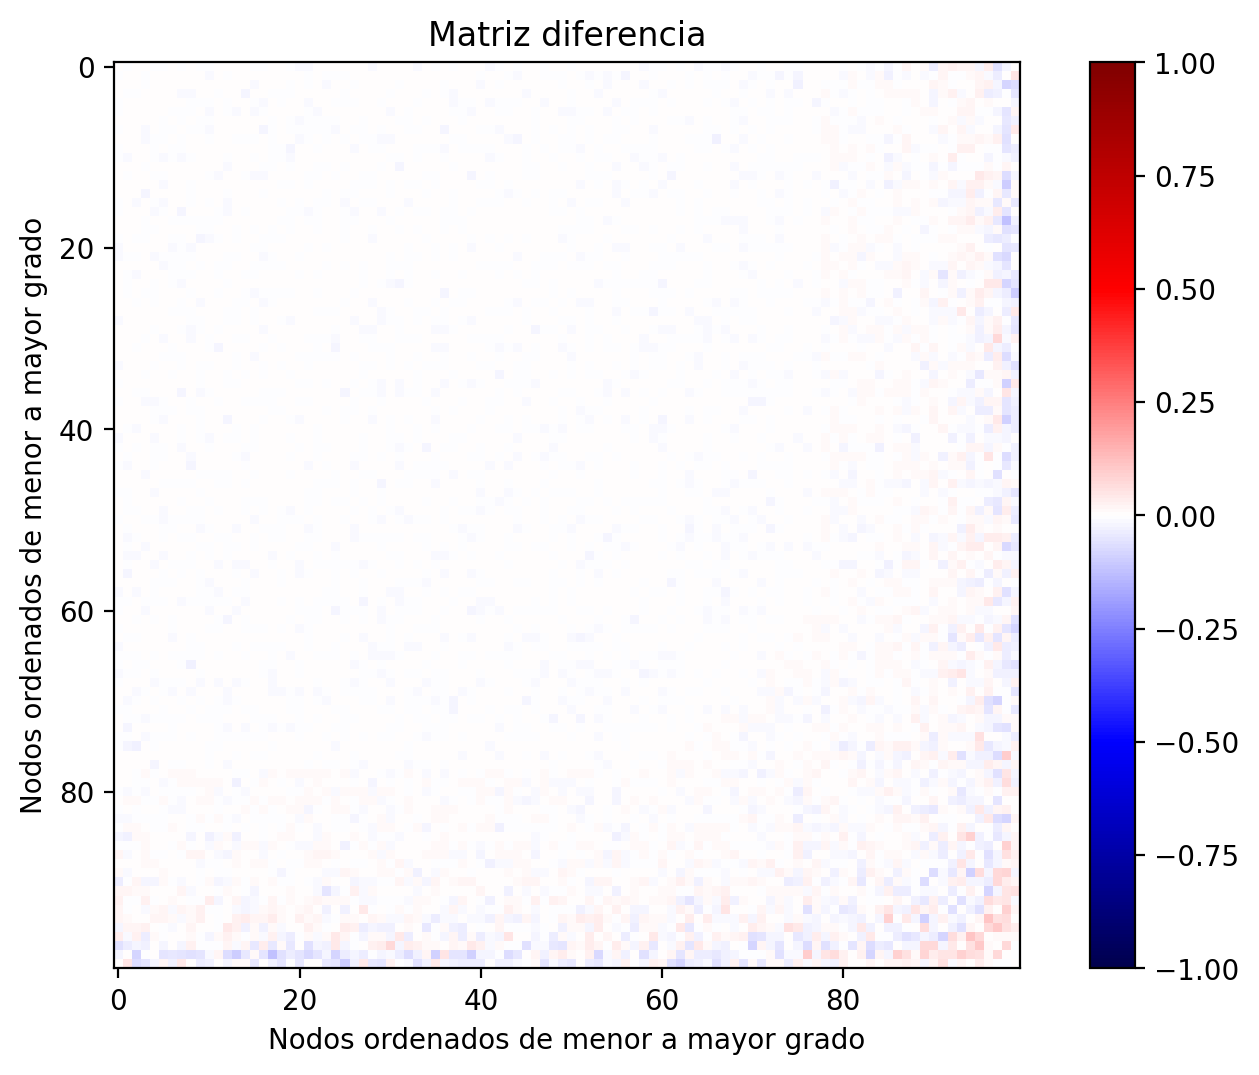

In [ ]:
fig = plt.figure(figsize=(9,6), dpi = 200)
plt.imshow(DIFF,cmap = "seismic",vmin = -1,vmax = 1)
plt.xlabel("Nodos")
plt.ylabel("Nodos")
plt.title("Matriz diferencia")
plt.xlabel("Nodos ordenados de menor a mayor grado")
plt.ylabel("Nodos ordenados de menor a mayor grado")
plt.colorbar()
plt.savefig("adj_diff.jpg", bbox_inches='tight', dpi=300)
plt.show()


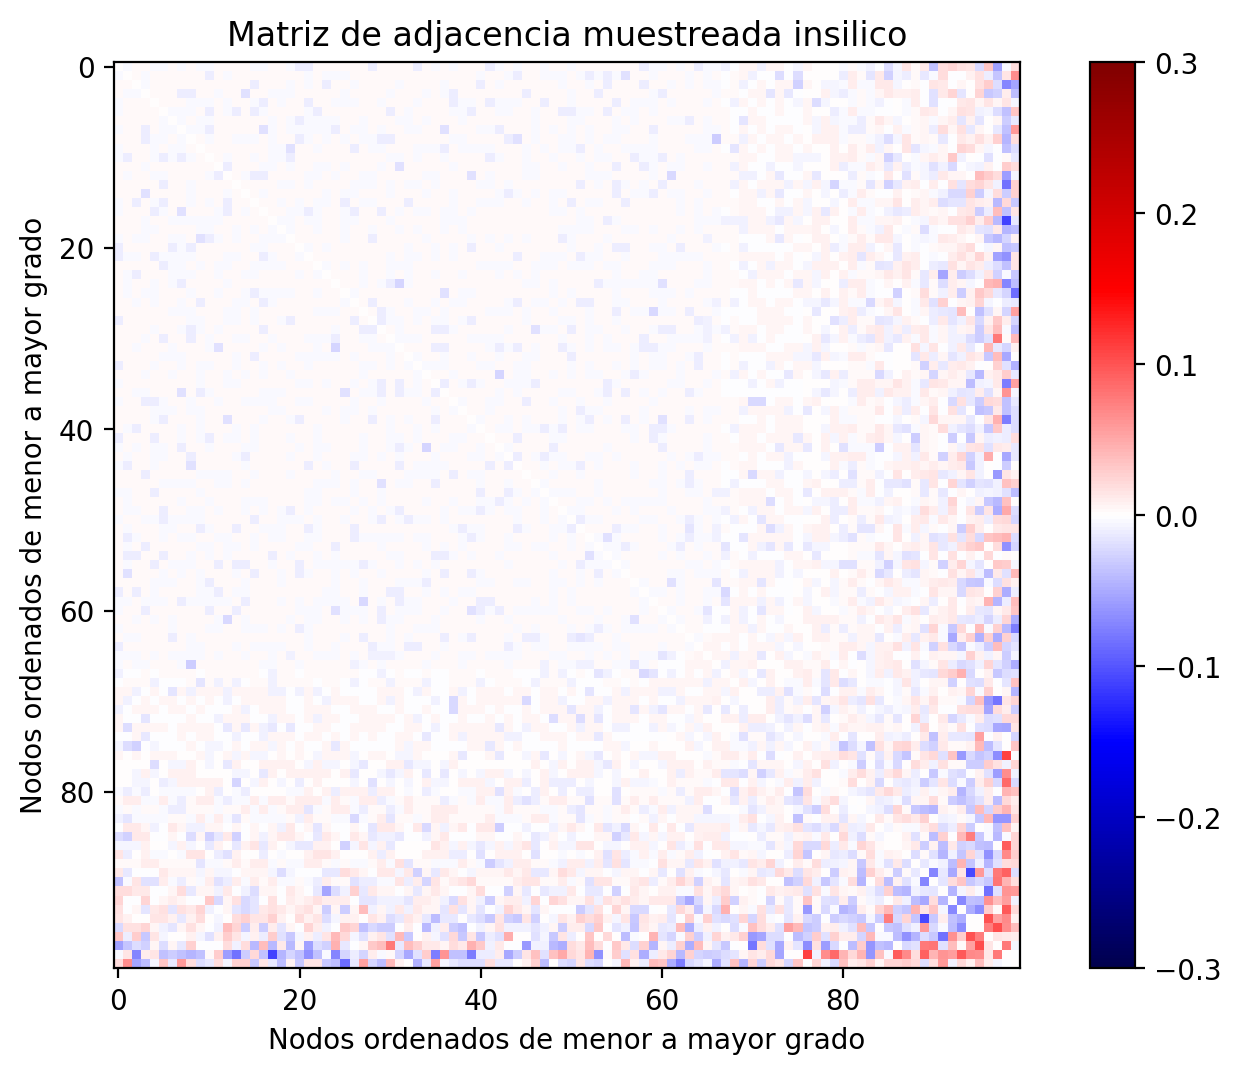

In [ ]:

fig = plt.figure(figsize=(9,6), dpi = 200)
plt.imshow(DIFF2,cmap = "seismic",vmin = -0.3,vmax = 0.3)
plt.xlabel("Nodos")
plt.ylabel("Nodos")
plt.title("Matriz de adjacencia muestreada insilico")
plt.xlabel("Nodos ordenados de menor a mayor grado")
plt.ylabel("Nodos ordenados de menor a mayor grado")
plt.savefig("adj_diff2.jpg", bbox_inches='tight', dpi=300)
plt.colorbar()
plt.show()


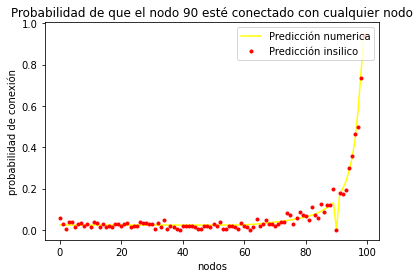

In [ ]:
plt.plot(adj[90],color = "yellow",label = "Predicción numerica")
plt.title("Probabilidad de que el nodo 90 esté conectado con cualquier nodo")
plt.xlabel("nodos")
plt.ylabel("probabilidad de conexión")
plt.plot(adj_insilico[90], color = "red", label = "Predicción insilico")
plt.legend(loc = 1 )
plt.savefig("p_nodo90.jpg", bbox_inches='tight', dpi=300)